ave total energy consumption:  0.095
total energy consumption:  3.147
min total energy consumption:  0.014
max total energy consumption:  0.226
diff max-min:  0.212
lora send:  232
lora receive:  232
ble send:  480
ble receive:  480
lora packet arrival probability:  100.0
ble packet arrival probability:  100.0
0.010438375465693183
1021683.6822467697
0.10216836822467697


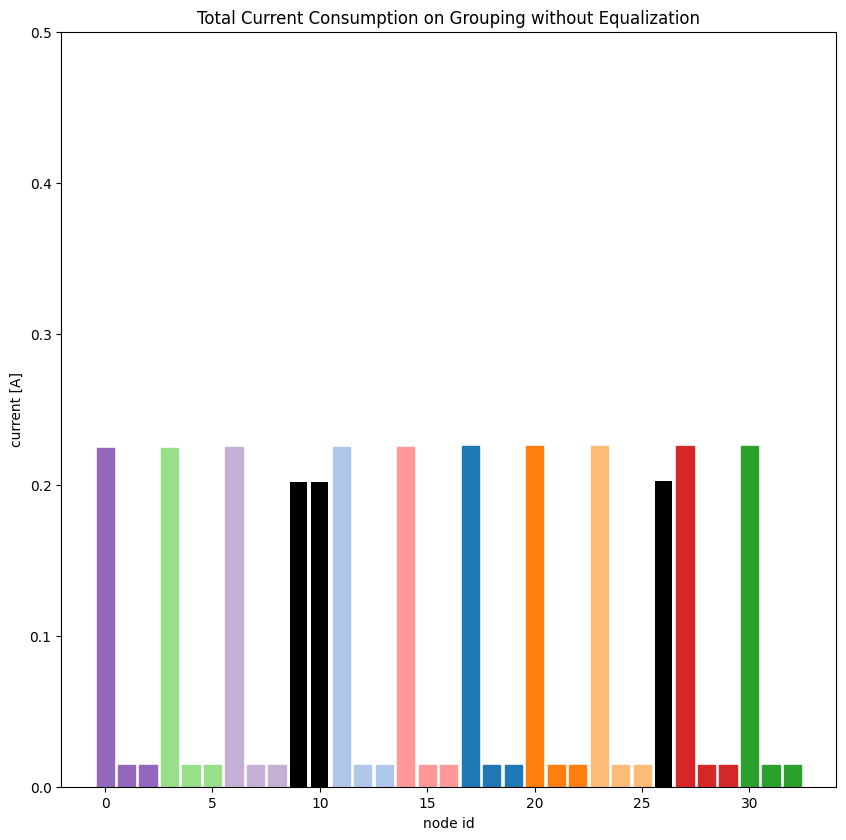

In [8]:
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
import dataclasses
import copy
import datetime
import operator

@dataclasses.dataclass
class NodeData:
    id: int
    pos_x: float
    pos_y: float
    pos_z: float
    lora_network_addr: str
    ble_network_addr: str
    activation_time: float
    connection_interval: float
    total_energy_consumption: float
    lora_energy_consumption: float
    ble_energy_consusmption: float
    cnt_leader: int
    lora_send: int
    lora_receive: int
    ble_send: int
    ble_receive: int

@dataclasses.dataclass
class GroupPair:
    id: int
    my_addr: int
    lora_net_addr: int

def removeDuplicates(lst): 
    return [t for t in (set(tuple(i) for i in lst))] 

file_suffix = "4hour"
csv_file = "/Users/tozastation/workspace/tozastation/simulate-lorawan/result/lorawan/" + file_suffix + ".csv"
group_csv_file = "/Users/tozastation/workspace/tozastation/simulate-lorawan/result/group_without_eq/" + file_suffix + ".csv"
node_datas = []
node_data_csv = pd.read_csv(group_csv_file)
# --- Output ---
print("ave total energy consumption: ", round(node_data_csv["total_energy_consumption"].mean(), 3))
print("total energy consumption: ", round(node_data_csv["total_energy_consumption"].sum(), 3))

min_lora_e = round(node_data_csv["total_energy_consumption"].min(), 3)
max_lora_e = round(node_data_csv["total_energy_consumption"].max(), 3)
print("min total energy consumption: ", round(min_lora_e, 3))
print("max total energy consumption: ", round(max_lora_e, 3))
print("diff max-min: ", round(max_lora_e-min_lora_e, 3))

lora_send = node_data_csv["lora_send"].sum()
lora_receive = node_data_csv["lora_receive"].sum()
ble_send = node_data_csv["ble_send"].sum()
ble_receive = node_data_csv["ble_receive"].sum()
print("lora send: ", lora_send)
print("lora receive: ", lora_receive)
print("ble send: ", ble_send)
print("ble receive: ", ble_receive)
print("lora packet arrival probability: ", lora_receive/lora_send * 100)
print("ble packet arrival probability: ", ble_receive/ble_send * 100)
print(node_data_csv["total_energy_consumption"].var())
print(node_data_csv["total_energy_consumption"].std() * 10**7 )
print(node_data_csv["total_energy_consumption"].std())
# ----------------
group_pair_csv_file = "/Users/tozastation/workspace/tozastation/simulate-lorawan/result/group_pair.csv"
group_pairs = []
group_pair_csv = pd.read_csv(group_pair_csv_file)

for index, row in node_data_csv.iterrows():
    node = NodeData(
        int(row[0]), 
        round(float(row[1]), 6),
        round(float(row[2]), 6),
        round(float(row[3]), 6),
        row[4],
        row[5],
        round(float(row[6]), 6),
        round(float(row[7]), 6),
        round(float(row[8]), 6),
        round(float(row[9]), 6),
        round(float(row[10]), 6),
        int(row[11]),
        int(row[12]),
        int(row[13]),
        int(row[14]),
        int(row[15])
    )
    node_datas.append(node)
#
for index, row in group_pair_csv.iterrows():
    group_pair = GroupPair(
        int(row[0]), 
        int(row[1]),
        row[2]
    )
    group_pairs.append(group_pair)
#
fig_e = plt.figure(figsize=(10, 10), dpi=100)
ax_e  = fig_e.add_subplot(111)
ax_e.set_title("Total Current Consumption on Grouping without Equalization")
ax_e.set_xlabel("node id")
ax_e.set_ylabel("current [A]")
ax_e.set_ylim(0, 0.5)

bar_list  = ax_e.bar('id', 'total_energy_consumption', data=node_data_csv, color='black')
#
groups = []
for group_pair in group_pairs:
    base_id = group_pair.id
    col     = []
    col.append(base_id)
    for b in group_pairs:
        if base_id == b.id:
            for c in group_pairs:
                if (b.lora_net_addr == c.my_addr) and (b.id != c.id):
                    col.append(c.id)
    groups.append(set(col))

sorted_list = removeDuplicates(groups)
new_list = []
cmap = plt.get_cmap("tab20")
group_node_datas = []
sorted_list = [item for item in sorted_list if len(item) > 2]
for i, l in enumerate(sorted_list):
    group_node_data = []
    for m in l:
        for j, node_data in enumerate(node_datas):
            if m==node_data.id:
                new_list.append((m, j))
                bar_list[j].set_color(cmap(i))
                group_node_data.append(node_data)
    group_node_datas.append(group_node_data)

plt.show()

# file_name = "group_without_eq_" + file_suffix + "_out_.png"
# fig_e.savefig("/Users/tozastation/workspace/tozastation/simulate-lorawan/output/group_without_eq/" + file_name)
# ---  ---- #

# ---  ---
# fig_ge = plt.figure(figsize=(10, 10), dpi=100)
# ax_ge  = fig_ge.add_subplot(111)
# ax_ge.set_title("Difference between Maximum and Minimum each Group")
# ax_ge.set_xlabel("group")
# ax_ge.set_ylabel("current [A]")
# ax_ge.set_ylim(0, 0.1)
# analyze_energy_consumption = []

# for group in group_node_datas:
#     group_ec = []
#     for node in group:
#         group_ec.append(node.total_energy_consumption)
#     analyze_energy_consumption.append(group_ec)

# print(analyze_energy_consumption)
# alphabet = ['A','B','C','D','E','F','G','H','I','J','K']
# for i, group_ec in enumerate(analyze_energy_consumption):
#     ave_e = sum(group_ec)/len(group_ec)
#     diff_max_e = max(group_ec) - ave_e
#     diff_min_e = abs(min(group_ec) - ave_e)
#     value = 0
#     if diff_max_e > diff_min_e:
#         value = diff_max_e
#     else:
#         value = diff_min_e
#     ax_ge.bar(alphabet[i], round(value,4), color=cmap(i))

# file_name = file_prefix + "_group_consumption_diff.png"
# fig_ge.savefig("/Users/tozastation/workspace/tozastation/simulate-lorawan/output/" + file_name)